In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
import statsmodels.api as sm
import itertools
from linearmodels import IV2SLS, IVLIML, IVGMM, IVGMMCUE
import copy

We observe $Y_i$ and $X_i$

We don't know if 

$Y_i = \alpha + \beta X_i + \varepsilon_i$

or

$Y_i = \alpha + \beta \log(X_i) + \varepsilon_i$



How do we determine which one is right?

We $i = 1,2, \ldots, N$

### Leave-One-Out LOO Cross Validation

For each i=1:N
Estimated the model without using observation $i$ 

We get $\hat{\alpha}_i$, $\hat{\beta}_i$ - parameters we get without using observation $i$

Take the fitted model and predict $Y_i$ by $\hat{Y}_i$
Calculate error $Y_i-\hat{Y}_i$

Calculate $ \sqrt{\frac{1}{N}\sum_{i=1}^N(Y_i-\hat{Y}_i)^2}$

### True DGP

Take first 999 observations - estimate the model 
This model hasn't seen observation no. 1000
When we predict using values for observation 1000

In [3]:
n = 1000

X = np.random.uniform(2,1,[n,1])
const = np.ones([n,1])
alpha = .3
beta = 1.5
err = np.random.normal(0,1,[n,1])

Y = alpha + beta*X+err


exvar = np.concatenate([const,X],axis = 1)
df.head()
df['const'] = 1
df['i'] = range(n)

In [29]:
i = 1
df_noti = df[df.i!=i]

In [30]:
dfi = df[df.i==i]

In [32]:
mod = sm.OLS(df_noti.Y,df_noti[['X','const']])

In [23]:
res.predict?

In [24]:
Yi_hat = res.predict(dfi[['X','const']])
Yi_hat

1    2.005983
dtype: float64

In [25]:
0.4281 + 1.4219 * 1.109661

2.0059269759

In [20]:
dfi

,Y,X,const,i
1,3.539801,1.109661,1,1


In [26]:
# mod = sm.OLS(df_noti.Y,df_noti[['X','const']])
# res = mod.fit()
# print(res.summary())

In [36]:
i = 1
df_noti = df[df.i!=i] # define df with obs i removed
dfi = df[df.i==i] # df with only obs i

mod = sm.OLS(df_noti['Y'],df_noti[['X','const']]) # estimate model without using observation i
res = mod.fit()


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     176.1
Date:                Fri, 12 Feb 2021   Prob (F-statistic):           3.98e-37
Time:                        16:36:50   Log-Likelihood:                -1409.5
No. Observations:                 999   AIC:                             2823.
Df Residuals:                     997   BIC:                             2833.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              1.4219      0.107     13.270      0.0

In [39]:
res = mod.fit()
Yi_hat = res.predict(dfi[['X','const']]) # predict Yihat using estimated parameters
float(Yi_hat)

2.005983229558119

In [42]:
float(dfi.Y)-float(Yi_hat)

1.533817462000394

In [46]:
float(dfi.Y),float(Yi_hat)

(3.5398006915585127, 2.005983229558119)

In [47]:
errors = []
for i in tqdm(range(n)): # for every i
    df_noti = df[df.i!=i] # define df with obs i removed
    dfi = df[df.i==i] # df with only obs i
    
    mod = sm.OLS(df_noti['Y'],df_noti[['X','const']]) # estimate model without using observation i
    res = mod.fit()
    Yi_hat = res.predict(dfi[['X','const']]) # predict Yihat using estimated parameters
    sqerr = (float(dfi.Y) - float(Yi_hat))**2 # true Yi - predicted Yi
    errors = errors + [sqerr]

100%|██████████| 1000/1000 [00:02<00:00, 459.23it/s]


Repeat exercise assuming incorrect model

In [49]:
df['logX'] = np.log(df.X)
errors2 = []
for i in tqdm(range(n)): # for every i
    df_noti = df[df.i!=i] # define df with obs i removed
    dfi = df[df.i==i] # df with only obs i
    
    mod = sm.OLS(df_noti['Y'],df_noti[['logX','const']]) # estimate model without using observation i
    res = mod.fit()
    Yi_hat = res.predict(dfi[['logX','const']]) # predict Yihat using estimated parameters
    sqerr = (float(dfi.Y) - float(Yi_hat))**2 # true Yi - predicted Yi
    errors2 = errors2 + [sqerr]

100%|██████████| 1000/1000 [00:02<00:00, 463.69it/s]


(array([688., 162.,  66.,  36.,  19.,   8.,  10.,   9.,   1.,   1.]),
 array([7.21411482e-07, 1.00126423e+00, 2.00252774e+00, 3.00379124e+00,
        4.00505475e+00, 5.00631826e+00, 6.00758176e+00, 7.00884527e+00,
        8.01010878e+00, 9.01137229e+00, 1.00126358e+01]),
 <BarContainer object of 10 artists>)

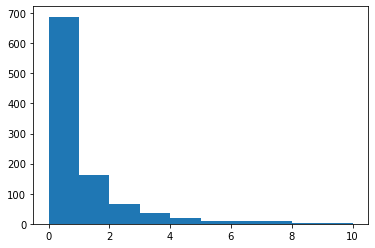

In [50]:
plt.hist(errors)

(array([692., 159.,  63.,  37.,  21.,   8.,  12.,   6.,   1.,   1.]),
 array([3.19719183e-06, 1.01125133e+00, 2.02249946e+00, 3.03374760e+00,
        4.04499573e+00, 5.05624386e+00, 6.06749200e+00, 7.07874013e+00,
        8.08998826e+00, 9.10123639e+00, 1.01124845e+01]),
 <BarContainer object of 10 artists>)

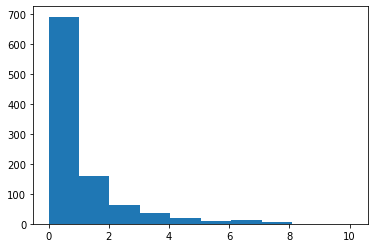

In [51]:
plt.hist(errors2)

In [57]:
np.sqrt(np.mean(errors))-np.sqrt(np.mean(errors2))

-0.00024815520169518823